<a href="https://colab.research.google.com/github/AlyGamalAbusenna/Iris-Multi-class-Classification/blob/main/Deep2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Import Libreries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 2) Uploade dataset

In [2]:
# Load your provided dataset
df = pd.read_csv('iris - iris.csv')

# Inspect the dataset
print(df.head())

# Assuming the dataset follows the same structure: 4 features + 1 target (species)
X = df.iloc[:, :-1].values  # Features: all columns except the last
y = pd.Categorical(df.iloc[:, -1]).codes  # Convert species names to categorical codes

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to torch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


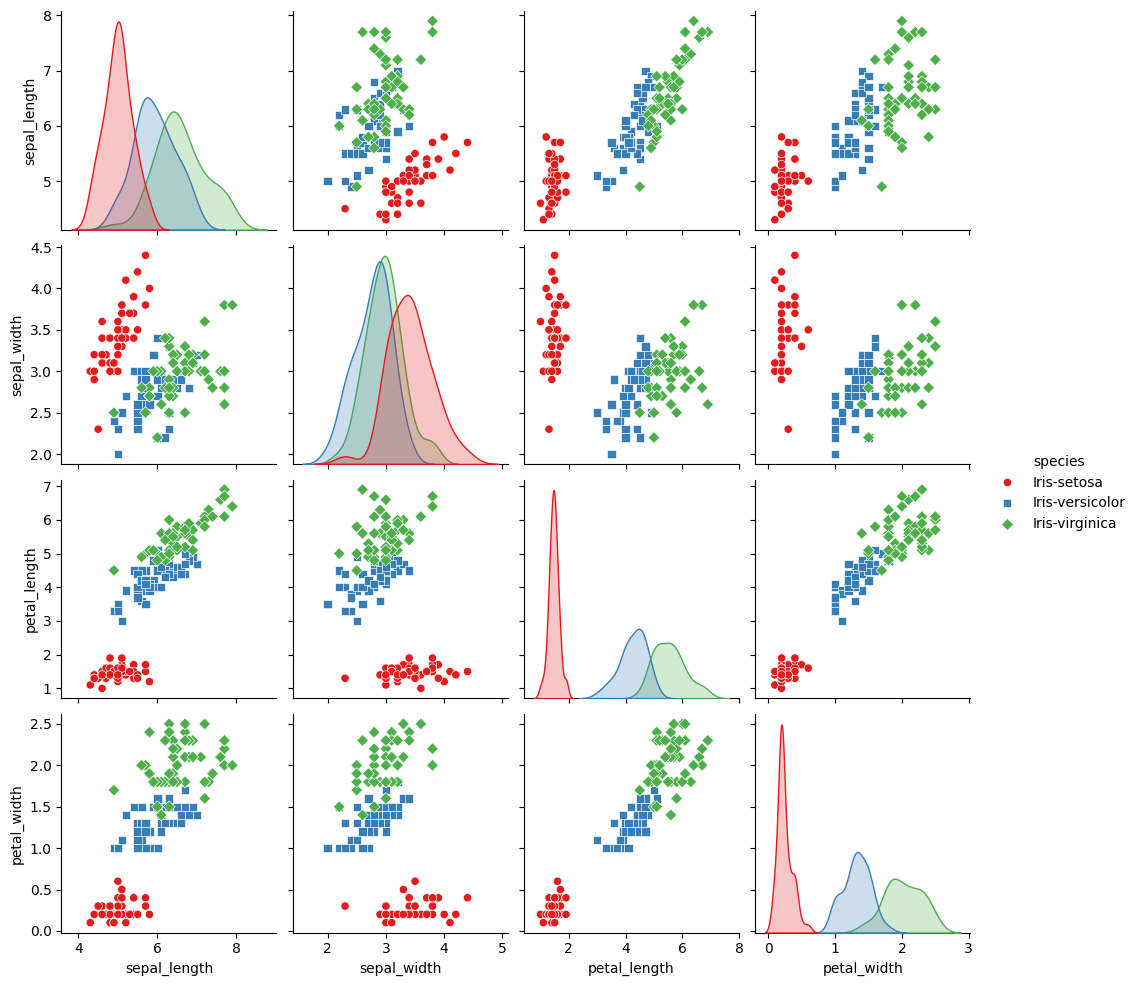

In [4]:
# Create a pairplot to show scatter plots of every two attributes
sns.pairplot(df, hue='species', markers=["o", "s", "D"], palette="Set1")
plt.show()

# 3) Build the Model

In [5]:
class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 12)
        self.fc3 = nn.Linear(12, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = IrisModel()


In [6]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# 4) Start Training

In [7]:
# Training the model
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses.append(loss.item())

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    val_outputs = model(X_test)
    val_loss = criterion(val_outputs, y_test)
    val_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')


Epoch [10/100], Training Loss: 0.7294, Validation Loss: 0.6745
Epoch [20/100], Training Loss: 0.4186, Validation Loss: 0.3689
Epoch [30/100], Training Loss: 0.2485, Validation Loss: 0.1847
Epoch [40/100], Training Loss: 0.1360, Validation Loss: 0.0885
Epoch [50/100], Training Loss: 0.0758, Validation Loss: 0.0700
Epoch [60/100], Training Loss: 0.0566, Validation Loss: 0.0387
Epoch [70/100], Training Loss: 0.0498, Validation Loss: 0.0238
Epoch [80/100], Training Loss: 0.0469, Validation Loss: 0.0213
Epoch [90/100], Training Loss: 0.0452, Validation Loss: 0.0188
Epoch [100/100], Training Loss: 0.0441, Validation Loss: 0.0164


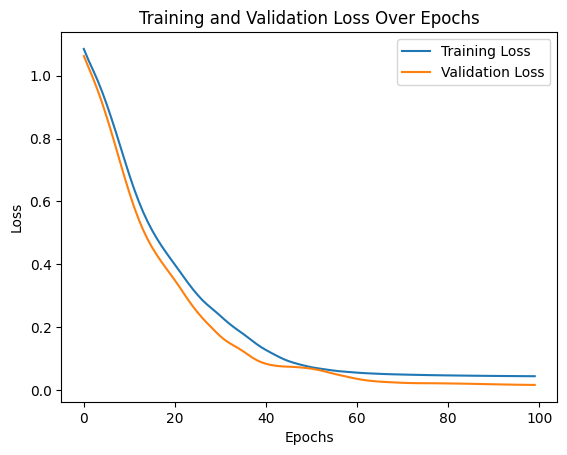

In [8]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


# 5) Model Evaluation

Training Accuracy: 0.98
Test Accuracy: 1.00


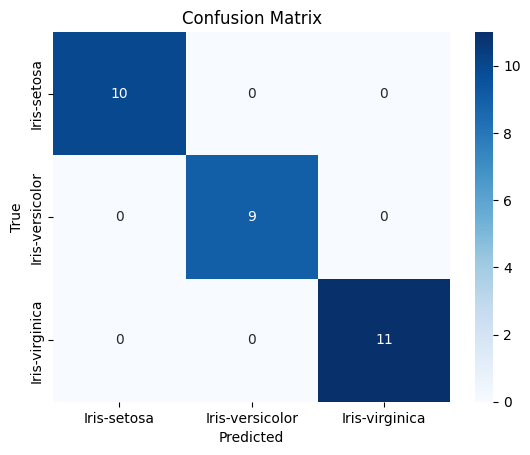

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



In [9]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).argmax(dim=1)
    y_pred_test = model(X_test).argmax(dim=1)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f'Training Accuracy: {train_acc:.2f}')
print(f'Test Accuracy: {test_acc:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df.iloc[:, -1].unique(), yticklabels=df.iloc[:, -1].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test, target_names=df.iloc[:, -1].unique()))


ROC-AUC Score: 1.00


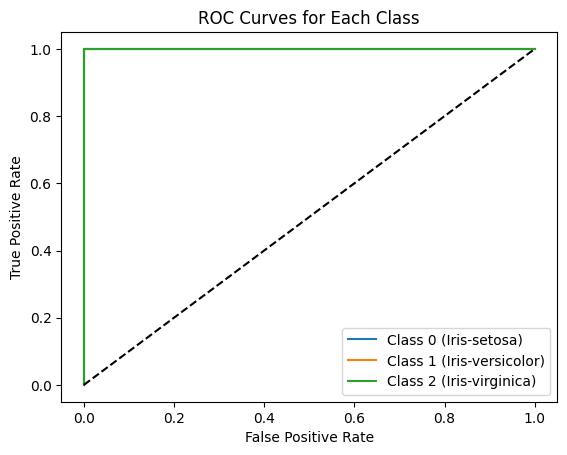

In [10]:
y_test_binarized = pd.get_dummies(y_test).values
y_pred_prob = F.softmax(model(X_test), dim=1).detach().numpy()

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc:.2f}')

# ROC curve
fpr = {}
tpr = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ({df.iloc[:, -1].unique()[i]})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="best")
plt.show()


## It seems that the model is perfect as the task is not hard and the data is clean and balanced, also the classes can be easly separeted as shown in the scatter plot.